<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам

# <center>Неделя 7.  Финальное задание и Соревнование Kaggle "Catch Me If You Can"
    
Задача сделать детальный анализ данных и получить максимальный бал в этом соревновании который получится.

In [1]:
%load_ext watermark
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.6.4
IPython 6.2.1

numpy 1.14.0
scipy 0.19.1
pandas 0.24.2
matplotlib 3.1.1
statsmodels 0.8.0
sklearn 0.19.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 78 Stepping 3, GenuineIntel
CPU cores  : 4
interpreter: 64bit
Git hash   : 7c380f689acd8773171e8df2db07296789494474


In [537]:
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
import matplotlib
print(pd.__version__)
print(matplotlib.__version__)

0.24.2
3.1.1


In [503]:
def fullPrintNumpy(array):
    old_print_threshold = np.get_printoptions()['threshold']
    np.set_printoptions(threshold=np.nan)
    print(array)
    np.set_printoptions(threshold=old_print_threshold)    

In [515]:
def fullPrintPandasHead(frame, head=5):
    pd.set_option('display.max_colwidth', -1)
    print(frame.head(head))
    pd.reset_option('display.max_colwidth')

In [4]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'kaggle'

In [5]:
times = ['time%s' % i for i in range(1, 11)]
sites = ['site%s' % i for i in range(1, 11)]

In [90]:
%%time
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), 
                       index_col='session_id', parse_dates = times)
train_df.fillna({site:0 for site in sites}, inplace = True)
train_df.sort_values(by='time1', inplace=True)

test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id', parse_dates = times)
test_df.fillna({site:0 for site in sites}, inplace = True)

y = train_df.target.values

Wall time: 4.22 s


In [7]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,0.0,NaT,0.0,NaT,0.0,NaT,...,NaT,0.0,NaT,0.0,NaT,0.0,NaT,0.0,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,0.0,NaT,...,NaT,0.0,NaT,0.0,NaT,0.0,NaT,0.0,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


Check that no targets are missing. Number of missing values:  0 0 0
Value counts for target:
0    251264
1      2297
Name: target, dtype: int64


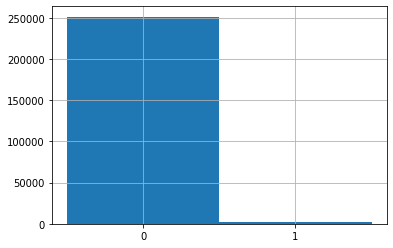

In [8]:
print("Check that no targets are missing. Number of missing values: ", 
      train_df.target.isna().sum(), len(train_df[train_df.site1 == 0]), train_df.time1.isna().sum())
print("Value counts for target:")
print(train_df.target.value_counts())
ax = train_df.target.hist(bins=range(3))
ax.set_xticks(np.arange(2) + 0.5)
_ = ax.set_xticklabels(range(2))

According to the target class labels we are going to deal with unbalanced binary classification. It might be a good idea to try different options to either balance the data (bootstrap or SMOTE or stratification if applies, in other words downsampling/upsampling) or penalize errors on minor class and use the correct metric (accuracy is not the one). 

In [579]:
hosts = pd.read_pickle(os.path.join(PATH_TO_DATA, 'site_dic.pkl'))
idToHost = {v:k for k,v in hosts.items()}
hosts_df = pd.DataFrame.from_dict(idToHost, orient='index', columns=['host'])

In [711]:
hosts_df.head()

,host,host_clean
25075,www.abmecatronique.com,abmecatronique.com
13997,groups.live.com,groups.live.com
42436,majeureliguefootball.wordpress.com,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu,hdwallpapers.eu


In [745]:
# let's do some cleanup
def removeWWW(x):
    return x.replace('www.','') if x.startswith('www') else x

hosts_df.host_clean = hosts_df.host.apply(removeWWW)
print(removeWWW('www.apache.org'))
print(removeWWW('wwwapache.org'))
print(removeWWW('lerwww.apache.org'))

apache.org
wwwapache.org
lerwww.apache.org


In [680]:
#key function is reverse of the string, no built-in reverse
sorted([x for x in hosts if x.endswith('abmecatronique.com')], key=lambda x: x[::-1])

['abmecatronique.com', 'www.abmecatronique.com']

In [751]:
from collections import Counter
Counter(hosts_df.host_clean).most_common()

[('abmecatronique.com', 2),
 ('carolineconduiteformation.com', 2),
 ('uqo.ca', 2),
 ('score.org', 2),
 ('bladi.net', 2),
 ('aol.fr', 2),
 ('jeux.fm', 2),
 ('volcanogeol.com', 2),
 ('economieautrement.org', 2),
 ('france.attac.org', 2),
 ('terresacree.org', 2),
 ('robotbuzz.fr', 2),
 ('google.ru', 2),
 ('perlmonks.org', 2),
 ('blablacar.fr', 2),
 ('doingbusiness.ro', 2),
 ('grooveshark.fr', 2),
 ('exashare.com', 2),
 ('altairuniversity.com', 2),
 ('womenboxing.com', 2),
 ('1stwebdesigner.com', 2),
 ('duckduckgo.com', 2),
 ('indeed.fr', 2),
 ('maliweb.net', 2),
 ('lequipe.fr', 2),
 ('ozap.com', 2),
 ('letudiant.fr', 2),
 ('printoclock.com', 2),
 ('colorado.edu', 2),
 ('onsefaitchier.com', 2),
 ('hotmail.fr', 2),
 ('mp3.com', 2),
 ('france-paralympique.fr', 2),
 ('femmes.gouv.fr', 2),
 ('youssfi.net', 2),
 ('mathematex.net', 2),
 ('gothengine.com', 2),
 ('photo-luc-olivier.fr', 2),
 ('franceabris.com', 2),
 ('reserver1chambre.fr', 2),
 ('elsingulardigital.cat', 2),
 ('air-austral.com', 2)

In [744]:
hosts_df.loc[25074], hosts_df.loc[25075]

(host          abmecatronique.com
 host_clean    abmecatronique.com
 Name: 25074, dtype: object, host          www.abmecatronique.com
 host_clean        abmecatronique.com
 Name: 25075, dtype: object)

It seems like most of the sites have 3 domain levels. Also, domain zone might be an interesting feature, I don't think users usually visit domains in multiple zones. Let's quickly investigate that.

In [752]:
np.bincount([x.count('.') for x in hosts_df.host_clean])

array([    1, 15794, 20243, 11106,  1008,   134,    17,    57,     3,
           6,     0,     0,     0,     2], dtype=int64)

In [757]:
[x for x in sorted(hosts_df['host_clean']) if x.count('.') == 7]

['fastly.bench.cedexis.com.global.prod.fastly.net',
 'fp.profiles.us.playstation.com.s3.amazonaws.com',
 'lefigarohd.pd.ak.o.brightcove.com.edgesuite.net',
 'u-a940q501yg.b9.bkln.wc.s1.b.yahoodns.net',
 'u-absvkwr1ct.mi.bkln.wc.s1.b.yahoodns.net',
 'u-ac64j8bnr2.zux.bkln.wc.s1.b.yahoodns.net',
 'u-acoc92enzb.tj4.bkln.wc.s1.b.yahoodns.net',
 'u-add7il8qdv.jor.bkln.wc.s1.b.yahoodns.net',
 'u-aewuar5wo5.3xr.bkln.wc.s1.b.yahoodns.net',
 'u-akk52wo2q1.gl.bkln.wc.s1.b.yahoodns.net',
 'u-an249tcwpd.zfr.bkln.wc.s1.b.yahoodns.net',
 'u-anaebob5a9.nm.bkln.wc.s1.b.yahoodns.net',
 'u-aoye3sjl7x.7vi.bkln.wc.s1.b.yahoodns.net',
 'u-ap7oskz2pk.bt9.bkln.wc.s1.b.yahoodns.net',
 'u-apx5d3pd4.cxr.bkln.wc.s1.b.yahoodns.net',
 'u-at84dq70pv.66r.bkln.wc.s1.b.yahoodns.net',
 'u-atkd017wmh.7vi.bkln.wc.s1.b.yahoodns.net',
 'u-awkl4obo2c.vi.bkln.wc.s1.b.yahoodns.net',
 'u-axpo3mjfc5.0k9.bkln.wc.s1.b.yahoodns.net',
 'u-ay9n5vch1w.yb9.bkln.wc.s1.b.yahoodns.net',
 'u-ayc5f00w0v.zfr.bkln.wc.s1.b.yahoodns.net',
 'u-

Right, most of the sites have 1,2 or 3 sub domains.

In [12]:
site_id_zone = { site_id:host[host.rfind('.') + 1:] for host, site_id in hosts.items() }
site_id_zone

{25075: 'com',
 13997: 'com',
 42436: 'com',
 30911: 'eu',
 8104: 'eu',
 37491: 'us',
 5462: 'fr',
 35425: 'be',
 30151: 'com',
 38268: 'com',
 43641: 'com',
 36959: 'ca',
 40935: 'ca',
 12346: 'net',
 31023: 'com',
 31114: 'com',
 28165: 'net',
 31877: 'fr',
 31070: 'com',
 12938: 'net',
 42002: 'net',
 5671: 'com',
 32074: 'ch',
 7104: 'com',
 1939: 'net',
 6708: 'com',
 43589: 'fr',
 45241: 'com',
 16195: 'fr',
 23921: 'com',
 28449: 'com',
 14139: 'net',
 7082: 'com',
 46081: 'net',
 2599: 'fr',
 46307: 'tv',
 21319: 'org',
 3282: 'com',
 45634: 'com',
 28768: 'com',
 5451: 'fr',
 6185: 'fr',
 47973: 'net',
 31500: 'com',
 46861: 'net',
 40008: 'jp',
 437: 'com',
 17157: 'com',
 19864: 'net',
 28747: 'com',
 34741: 'ch',
 30461: 'com',
 2321: 'fr',
 44216: 'com',
 22894: 'com',
 48066: 'ru',
 43454: 'com',
 40738: 'org',
 12037: 'com',
 34376: 'net',
 18052: 'net',
 30498: 'com',
 31715: 'net',
 32389: 'com',
 45741: 'nl',
 34839: 'com',
 5305: 'net',
 10938: 'com',
 32449: 'com',


# Models evaluation

In [13]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

## Cross validation

In [206]:
def plot_coefficients(classifier, feature_names, top_features=20):
   coef = classifier.coef_.ravel()
   top_positive_coefficients = np.argsort(coef)[-top_features:]
   top_negative_coefficients = np.argsort(coef)[:top_features]
   top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
   # create plot
   plt.figure(figsize=(15, 5))
   colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
   plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
   feature_names = np.array(feature_names)
   plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
   plt.show()

Since we have a time-series based data, let's use sorted by time1 data and use appropriate model for cross validation.
TimeSeriesSplit.

In [40]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, validation_curve, learning_curve

In [481]:
def hostToDomain(host):
    return ' '.join(host.replace('www.','').rsplit('.')[-2:-1])

def sitesToText(sites):
    hosts = [hostToDomain(idToHost[site_id]) for site_id in sites if site_id != 0]
    return ' '.join(hosts)

hostToDomain('www.domain4.domain3.apache.org')

'apache'

In [482]:
%%time
train_test_sorted_df = pd.concat([train_df, test_df], sort=False)
train_test_sorted_df_sites = train_test_sorted_df[sites].astype('int')
train_test_sorted_df_sites['word'] = train_test_sorted_df_sites \
    .apply(sitesToText, axis=1)

Wall time: 9.78 s


In [516]:
fullPrintPandasHead(train_test_sorted_df_sites[])

            site1  site2  site3  site4  site5  site6  site7  site8  site9  \
session_id                                                                  
21669       56     55     0      0      0      0      0      0      0       
54843       56     55     56     55     0      0      0      0      0       
77292       946    946    951    946    946    945    948    784    949     
114021      945    948    949    948    945    946    947    945    946     
146670      947    950    948    947    950    952    946    951    946     

            site10  \
session_id           
21669       0        
54843       0        
77292       946      
114021      946      
146670      947      

                                                                               word  
session_id                                                                           
21669       google google                                                            
54843       google google google google        

In [530]:
target_tfidf = CountVectorizer() #max_df=0.1, binary=True
target_tfidf.fit(train_test_sorted_df_sites[train_df.target == 1].word)
voc = target_tfidf.vocabulary_
#print(voc)

# sites need to be vectorized into sparse matrix, so each site is a feature
vectorizer = TfidfVectorizer(vocabulary=voc, binary=True, smooth_idf=False, use_idf=False) #max_df=0.1, binary=True
X2 = vectorizer.fit_transform(train_test_sorted_df_sites.word)

X_train_sorted_sparse = X2[:len(train_df)]
X_test_sparse = X2[len(train_df):]
print(X_train_sorted_sparse.shape)

(253561, 953)


In [531]:
for site in set('apache apache eclipse apache apache webtide oracle oracle caucho apache'.split()):
    if site in voc:
        print(site, voc[site], sep=':')

oracle:631


In [534]:
index = 2
print(np.argmax(X_train_sorted_sparse[index]))
fullPrint(X_train_sorted_sparse[index].A)

631
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [276]:
cv = TimeSeriesSplit(n_splits=10)

In [522]:
model = SGDClassifier(loss='log', random_state=17, n_jobs=-1)
cv_scores = cross_val_score(model, X_train_sorted_sparse, y, cv=cv, scoring='roc_auc', n_jobs=-1)
cv_scores, cv_scores.mean()

(array([0.72444725, 0.57565154, 0.83880072, 0.87033781, 0.80626718,
        0.87053277, 0.82046914, 0.88506016, 0.80896075, 0.88416525]),
 0.8084692561556158)

In [195]:
def fit_and_submit(model, train, y, test, name='submit.csv'):
    model.fit(train, y)
    pred_proba = model.predict_proba(test)
    write_to_submission_file(pred_proba[:,1], os.path.join(PATH_TO_DATA, name))

In [468]:
model = SGDClassifier(loss='log', random_state=17, n_jobs=-1)
fit_and_submit(model, X_train_sorted_sparse, y, X_test_sparse, 'submit-words.csv')

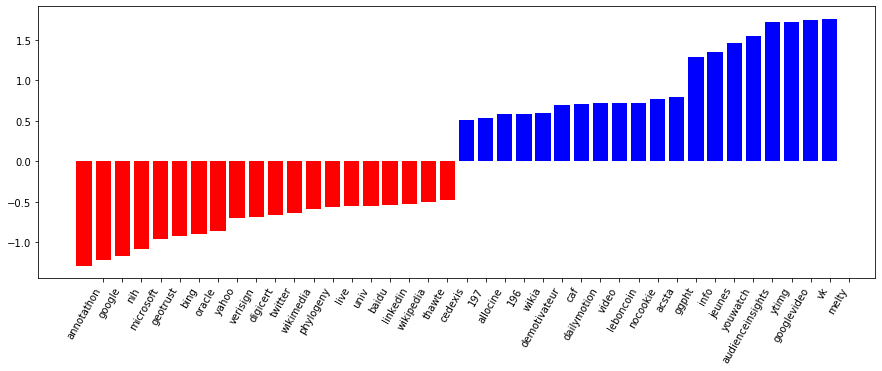

In [469]:
plot_coefficients(model, vectorizer.get_feature_names())

## Additional Features

In [268]:
def train_test(train_in, test_in, additional_features):
    train_out = hstack([train_in, additional_features[:len(train_df)]], format='csr')
    test_out = hstack([test_in, additional_features[len(train_df):]], format='csr')
    return train_out, test_out

In [269]:
def fit_and_submit(model, train, y, test, name='submit.csv'):
    model.fit(train, y)
    pred_proba = model.predict_proba(test)
    write_to_submission_file(pred_proba[:,1], os.path.join(PATH_TO_DATA, name))

Let's add zone of the first site and see if it changes the result anyhow.

In [270]:
additional_features = pd.DataFrame(index=train_test_sorted_df_sites.index)

In [271]:
from datetime import datetime

def extract_features(row):
    start_dt = row.time1
    return start_dt.hour, start_dt.weekday(), start_dt.month

In [272]:
additional_features['start_hour'], additional_features['start_day'], additional_features['start_month'] = zip(*train_test_sorted_df.apply(extract_features, axis=1))

categorical_columns = ['start_hour', 'start_day', 'start_month']
start_time_features = pd.get_dummies(additional_features[categorical_columns], columns=categorical_columns)
start_time_features.head()

,start_hour_7,start_hour_8,start_hour_9,start_hour_10,start_hour_11,start_hour_12,start_hour_13,start_hour_14,start_hour_15,start_hour_16,...,start_month_3,start_month_4,start_month_5,start_month_6,start_month_7,start_month_8,start_month_9,start_month_10,start_month_11,start_month_12
session_id,,,,,,,,,,,,,,,,,,,,,
21669,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54843,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
77292,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
114021,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
146670,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [273]:
train, test = train_test(X_train_sorted_sparse, X_test_sparse, start_time_features)
print(train.shape, test.shape)

(253561, 1034) (82797, 1034)


In [274]:
cv_scores = cross_val_score(model, train, y, cv=cv, scoring='roc_auc', n_jobs=-1)
print(cv_scores, cv_scores.mean())

fit_and_submit(model, train, y, test, name="final-start-time.csv")

[0.78389801 0.85717364 0.96440991 0.96628118 0.94598364] 0.9035492758479743


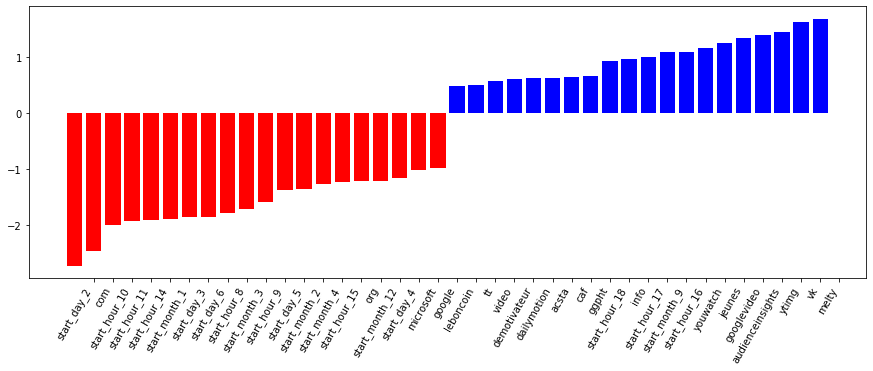

In [275]:
plot_coefficients(model, vectorizer.get_feature_names() + list(start_time_features))

In [412]:
corpus = [
     'word1 word2 word1 word1 word1 word1 word1 word1 word1 word2 word1 word2 word3 word3 word1 word1'
]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())
print(X.shape)
X.A

['word1', 'word2', 'word3']
(5, 3)


array([[0.90554997, 0.42423963, 0.        ],
       [0.96269032, 0.27060553, 0.        ],
       [0.41372929, 0.58148208, 0.70050458],
       [0.50854232, 0.        , 0.861037  ],
       [1.        , 0.        , 0.        ]])

In [463]:
corpus = [
     'word1 word1',
    'word1 word2 word1 word1',
    'word1 word2 word2',
    'word1 word2 word2 word2',
    'word1 word2 word2 word2',
    'word1 word2 word2 word2',
    'word1 word2 word2 word2',
    'word1 word2 word2 word2'
]
vectorizer = TfidfVectorizer(binary=True, smooth_idf=False)
vectorizer.fit(corpus)
X = vectorizer.transform(corpus)
print(vectorizer.get_feature_names())
print(X.shape)
X.A

['word1', 'word2']
(8, 2)


array([[1.        , 0.        ],
       [0.66155663, 0.74989521],
       [0.66155663, 0.74989521],
       [0.66155663, 0.74989521],
       [0.66155663, 0.74989521],
       [0.66155663, 0.74989521],
       [0.66155663, 0.74989521],
       [0.66155663, 0.74989521]])